In [9]:
from typing import List, Tuple

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import make_pipeline
import seaborn as sns
from feature_engineering.pipe.baseline import Baseline
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = None

In [10]:
df_train = pd.read_csv("../data/train.csv")

df_train_copy = df_train.copy()

### 苗字によって三親の関係を割り出す

In [11]:
df_train_copy["LastName"] = df_train_copy["Name"].apply(lambda x: x.split(",")[0])
df_train_copy["FamilyCount"] = df_train_copy["SibSp"] + df_train_copy["Parch"] + 1

df_train_copy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,FamilyCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Johnston,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Behr,1


In [12]:
df_train_copy["AdultMale"] = (
    (df_train_copy["Age"] > 16)
    & (df_train_copy["Sex"] == "male")
    & (df_train_copy["FamilyCount"] > 2)
)
df_train_copy["FemaleOrChild"] = (df_train_copy["Age"] <= 16) | (
    (df_train_copy["Sex"] == "female") | (df_train_copy["FamilyCount"] > 2)
)

df_train_copy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,FamilyCount,AdultMale,FemaleOrChild
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,2,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,2,False,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,1,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,2,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila,1,False,False
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham,1,False,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Johnston,4,False,True
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Behr,1,False,False


### チケット番号が同じ人は運命をともにしやすく、人数が多いほど死にやすそう

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: TicketCount, Length: 891, dtype: int64


<Axes: xlabel='TicketCount', ylabel='Survived'>

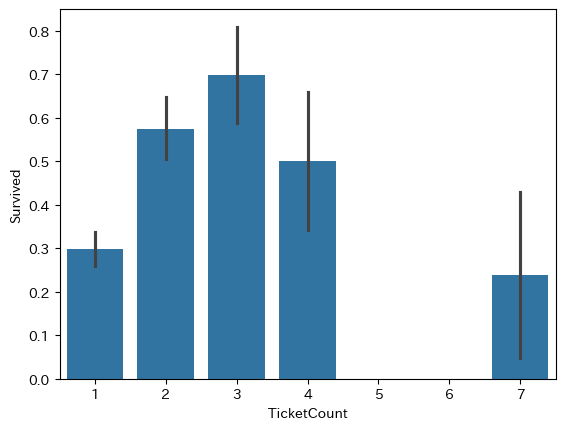

In [13]:
df_train_copy["TicketCount"] = df_train_copy.groupby("Ticket")["Ticket"].transform(
    "count"
)

print(df_train_copy["TicketCount"])

sns.barplot(x="TicketCount", y="Survived", data=df_train_copy)

/var/folders/1w/52jfb36j6sg557p8z_gknglh0000gn/T/ipykernel_20512/2834848814.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="TicketLabel", y="Survived", data=df_train_copy, palette="Set3")


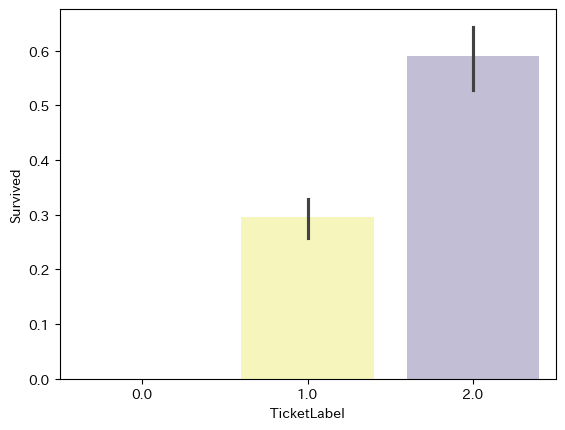

In [14]:
df_train_copy.loc[
    (df_train_copy["TicketCount"] >= 2) & (df_train_copy["TicketCount"] <= 4),
    "TicketLabel",
] = 2
df_train_copy.loc[
    (df_train_copy["TicketCount"] == 7) | (df_train_copy["TicketCount"] == 1),
    "TicketLabel",
] = 1
df_train_copy.loc[
    (df_train_copy["TicketCount"] == 5) | (df_train_copy["TicketCount"] == 6),
    "TicketLabel",
] = 0
sns.barplot(x="TicketLabel", y="Survived", data=df_train_copy, palette="Set3")
plt.show()

In [15]:
bl = Baseline(
    train_file_path="../data/train.csv",
)

# bl.add_feature(feature=df_train_copy["AdultMale"])
# bl.add_feature(feature=df_train_copy["FemaleOrChild"])
bl.add_feature(feature=df_train_copy["TicketLabel"])

impls, score = bl.run()

print(score)
print(impls)

0.8328102441780179
           feature  importance
0             Fare        1005
1           Pclass          87
2     Title_Master          16
3       Title_Miss          69
4         Title_Mr          74
5        Title_Mrs          68
6    Title_Officer           0
7    Title_Royalty           0
8              Age        1017
9       FamilySize         144
10  Cabin_Prefix_B          12
11  Cabin_Prefix_C          30
12  Cabin_Prefix_D          22
13  Cabin_Prefix_E          27
14  Cabin_Prefix_N          61
15     TicketLabel          40


In [16]:
model = bl.get_model()

In [17]:
df = pd.read_csv("../data/train.csv")

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df["Surname"] = df["Name"].map(lambda name: name.split(",")[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df["FamilyGroup"] = df["Surname"].map(df["Surname"].value_counts())

Female_Child_Group = df.loc[
    (df["FamilyGroup"] >= 2) & ((df["Age"] <= 16) | (df["Sex"] == "female"))
]
Female_Child_Group = Female_Child_Group.groupby("Surname")["Survived"].mean()
print(Female_Child_Group.value_counts())

Male_Adult_Group = df.loc[
    (df["FamilyGroup"] >= 2) & (df["Age"] > 16) & (df["Sex"] == "male")
]
Male_Adult_List = Male_Adult_Group.groupby("Surname")["Survived"].mean()
print(Male_Adult_List.value_counts())

# デッドリストとサバイブリストの作成
Dead_list = set(Female_Child_Group[Female_Child_Group.apply(lambda x: x == 0)].index)
Survived_list = set(Male_Adult_List[Male_Adult_List.apply(lambda x: x == 1)].index)

# デッドリストとサバイブリストの表示
print("Dead_list = ", Dead_list)
print("Survived_list = ", Survived_list)

Survived
1.000000    77
0.000000    27
0.750000     2
0.500000     1
0.333333     1
0.142857     1
Name: count, dtype: int64
Survived
0.000000    70
1.000000    14
0.500000     4
0.333333     1
Name: count, dtype: int64
Dead_list =  {'Arnold-Franchi', 'Jussila', 'Rice', 'Lobb', 'Attalah', 'Lefebre', 'Oreskovic', 'Palsson', 'Rosblom', 'Zabour', 'Strom', 'Goodwin', 'Panula', 'Skoog', 'Vander Planke', 'Cacic', 'Johnston', 'Olsson', 'Sage', 'Barbara', 'Elias', 'Ford', 'Turpin', 'Danbom', 'Boulos', 'Van Impe', 'Bourke'}
Survived_list =  {'Daly', 'Duff Gordon', 'Flynn', 'Frauenthal', 'Jussila', 'Nakid', 'Taylor', 'Bishop', 'Beane', 'Beckwith', 'Chambers', 'Goldenberg', 'Dick', 'Hoyt'}


In [ ]:
# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[
    (df["Survived"].isnull()) & (df["Surname"].apply(lambda x: x in Dead_list)),
    ["Sex", "Age", "Title"],
] = ["male", 28.0, "Mr"]
df.loc[
    (df["Survived"].isnull()) & (df["Surname"].apply(lambda x: x in Survived_list)),
    ["Sex", "Age", "Title"],
] = ["female", 5.0, "Mrs"]